# MNIST DIGIT CLASSIFIER
A simple 2 hidden layer learner class made for recognizing MNIST digits between 0 and 9

All neural network code was created from scratch with no machine learning specific libraries

PyTorch tensors were used as the data storage and data matrix representations of choice to speed up calculations and to enable training on a GPU

FastAI was used to download and open the MNIST dataset

PyTorch .backward() and .requires_grad_() were used to obtain the graditents needed to execute batch gradient descent.

All other code was written from scratch by Sasha Kiselev with inspiration and explanation from "Practical Deep Learning for Coders" by Jeremy Howard

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [2]:
train_paths = (path/'training').ls().sorted()
valid_paths = (path/'testing').ls().sorted()
train_paths, valid_paths

((#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')],
 (#10) [Path('testing/0'),Path('testing/1'),Path('testing/2'),Path('testing/3'),Path('testing/4'),Path('testing/5'),Path('testing/6'),Path('testing/7'),Path('testing/8'),Path('testing/9')])

#### Dataloader creation - should be changed to have all categories

In [3]:
train_x_lst = [tensor(Image.open(file)) for cat in train_paths for file in cat.ls()]
train_x_tns = torch.stack(train_x_lst)
# change rank 3 tns to rank 2 tns so that each example is 1 row
train_x_tns = train_x_tns.view(-1, 28*28)
# normalize all greyscale values
train_x_tns = train_x_tns.float()/255  

<AxesSubplot:>

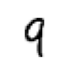

In [4]:
show_image(train_x_tns[55000].view(28,28), cmap='Greys')

In [5]:
valid_x_lst = [tensor(Image.open(file)) for cat in valid_paths for file in cat.ls()]
valid_x_tns = torch.stack(valid_x_lst)
# change rank 3 tns to rank 2 tns so that each example is 1 row
valid_x_tns = valid_x_tns.view(-1, 28*28)
# normalize all greyscale values
valid_x_tns = valid_x_tns.float()/255 

<AxesSubplot:>

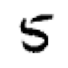

In [6]:
show_image(valid_x_tns[6000].view(28,28), cmap='Greys')

In [7]:
train_counts = [len(cat_path.ls()) for cat_path in train_paths]
valid_counts = [len(cat_path.ls()) for cat_path in valid_paths]

In [8]:
# make tensors of labels. As x is in order, labels also in order and depend only on the count 
# of examples in the folder, unsqueeze is needed to make it same rank as x
train_y_tns = L([])
for i, count in enumerate(train_counts):
    train_y_tns += L([i] * count)
train_y_tns = tensor(train_y_tns).unsqueeze(1)

valid_y_tns = L([])
for i, count in enumerate(valid_counts):
    valid_y_tns += L([i] * count)
valid_y_tns = tensor(valid_y_tns).unsqueeze(1)

In [9]:
train_dset = list(zip(train_x_tns, train_y_tns))
valid_dset = list(zip(valid_x_tns, valid_y_tns))

In [10]:
train_dl = DataLoader(train_dset, bs=256, shuffle=True)
valid_dl = DataLoader(valid_dset, bs=256, shuffle=True)

#### Model

In [11]:
def softmax(x):
    x = torch.exp(x)
    sum_exp = x.sum(dim = 1, keepdims = True)
    return x / sum_exp

In [53]:
def tanh(x):
    return (torch.exp(2*x) - 1) / (torch.exp(2*x) + 1)

In [43]:
class TwoHLLearner:
    
    def __init__(self, dls, n_hs, n_cat, lr=0.65): 
        # dls - tuple of train dataloader and valid dataloader respectivly
        # n_hs tuple neurons in hidden layer 1 and 2 respectivly
        n_h1, n_h2 = n_hs
        self.train_dl, self.valid_dl = dls
        self.lr = lr
        
        
        
        # initialize all parameters of the model and save them for tuple for easy passing
        self.w1, self.b1 = self.init_param((28*28, n_h1)), self.init_param((1, n_h1))
        self.w2, self.b2 = self.init_param((n_h1, n_h2)), self.init_param((1, n_h2))
        self.w3, self.b3 = self.init_param((n_h2, n_cat)), self.init_param((1))
        self.params = self.w1, self.b1, self.w2, self.b2, self.w3, self.b3
    
    def init_param(self, shape, scale=0.1): 
        return (torch.randn(shape) * scale).requires_grad_()
    
    def fit(self, num_epochs):
        for i in range(num_epochs):
            self.train_epoch()
            
    def train_epoch(self):
        for xb, yb in self.train_dl:
            # make prediction and get gradient of all parameters
            pred = self.model(xb)
            loss = self.loss_cross_ent(pred, yb)
            loss.backward()
            # update parameters and make sure to reset grad back to zero 
            # as grad adds up
            for p in self.params:
                p.data -= self.lr * p.grad
                if torch.isnan(p.max()):  # check and stop network if gradient explodes
                    print(loss, pred, xb)
                    print(p, p.grad)
                    raise ValueError("NaN found, breaking")
                p.grad.zero_()
        print(self.valid_acc(), end = "% ")
        #print(self.w1.max().item(), self.w2.max().item(), self.w3.max().item())
        
    def model(self, xb): 
        # basic linear relu linear relu model
        res = (xb @ self.w1 + self.b1).max(tensor(0.))
        res = (res @ self.w2 + self.b2).max(tensor(0.))
        res = tanh(res @ self.w3 + self.b3) # added to prevent exploding gradients
        return res
    
    def loss_binary(self, pred, target): 
        pred = pred.sigmoid()
        return torch.where(target == 1, 1 - pred, pred).mean()
    
    def loss_cross_ent(self, pred, target, epsilon=1e-8):
        pred = softmax(pred)
        targets = torch.zeros(pred.shape)
        indicies = torch.arange(pred.shape[0]), target.view(target.shape[0])
        values = torch.ones(pred.shape[0])
        targets.index_put_(indicies, values)
        return abs(targets - pred + epsilon).mean() # epsilon added to prevent everything being 0
                                
    def loss_mse(self, pred, target):
        pass
    def valid_loss(self):
        loss = 0.
        for xb, yb in self.valid_dl:
            pred = self.model(xb)
            loss += self.loss_multi(pred, yb)
        return loss
    
    def valid_acc(self):
        batch_accs = []
        for xb, yb in self.valid_dl:
            pred = self.model(xb)
            pred = pred.max(dim=1)[1]
            corrects = torch.where(pred == yb.view(yb.shape[0]), 1., 0.)
            batch_accs.append(corrects.mean())
        return round((tensor(batch_accs).mean().item() * 100), 2)

In [44]:
learner = TwoHLLearner((train_dl, valid_dl), (32, 16), 10)

In [45]:
learner.fit(256)

22.1% 49.6% 61.97% 74.0% 79.54% 83.63% 85.61% 87.02% 88.13% 88.6% 89.04% 89.68% 89.57% 90.09% 90.59% 90.79% 91.14% 91.2% 91.53% 91.62% 91.92% 91.62% 91.89% 91.6% 91.92% 92.35% 92.47% 92.33% 92.51% 92.73% 92.67% 92.34% 92.84% 92.92% 92.87% 93.1% 93.11% 93.22% 93.23% 93.17% 93.29% 93.13% 93.26% 93.52% 93.58% 93.14% 93.35% 93.59% 93.47% 93.43% 93.78% 93.61% 93.62% 93.97% 93.9% 93.74% 93.95% 94.07% 94.16% 94.16% 93.96% 93.94% 93.99% 94.2% 94.27% 94.2% 94.36% 94.42% 94.1% 94.26% 94.44% 94.07% 94.54% 94.06% 94.57% 94.2% 94.39% 94.58% 94.6% 94.48% 94.39% 94.51% 94.52% 93.96% 94.43% 94.78% 94.58% 94.82% 94.66% 94.84% 94.89% 94.79% 94.77% 94.85% 94.76% 94.73% 94.93% 94.74% 94.94% 94.83% 94.66% 94.86% 95.08% 95.0% 94.62% 95.05% 94.94% 95.05% 95.05% 94.96% 95.04% 94.79% 95.11% 95.1% 94.86% 95.18% 95.13% 94.98% 95.16% 95.13% 95.0% 95.14% 95.17% 95.02% 95.18% 95.19% 94.95% 94.88% 94.79% 95.09% 95.2% 95.12% 95.06% 95.0% 95.01% 95.26% 95.3% 95.05% 95.27% 95.18% 95.08% 95.26% 95.07% 95.35% 95.35% 95.2

Sometimes the model gets stuck around 80% accuracy on validation data, but most of the time with this training it is about to get to 95%-96% accuracy. After a succesful training run getting 95.95% I saved the model parameters to a text file for import into the inferer.

#### Save model parameters to a file to be used for the inferer

In [49]:
torch.save(learner.params, "95.92%_acc_parameters.pt")